# **Clasificare a sentimentelor din recenzii de filme folosind setul de date IMDB**
### *Folosind mai multe tehnici într-o abordare comprehensivă*

### 1.Importarea bibliotecilor

In [69]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt

### 2.Încarcarea si preprocesarea datelor

In [70]:
# Încărcarea datelor dintr-un fișier CSV
imdb_data = pd.read_csv('/content/sample_data/IMDB_Dataset.csv')

# Elimină rândurile cu valori lipsă din dataframe
imdb_data = imdb_data.dropna()

# Elimina randurile cu duplicate
imdb_data = imdb_data.drop_duplicates()

# Luarea unui eșantion de 1000 de rânduri pentru a accelera antrenarea și evaluarea
imdb_data_sample = imdb_data.sample(n=1000, random_state=42)

# Definirea caracteristicilor și etichetelor pentru clasificare
imdb_reviews = imdb_data['review'] # Coloanele text (fără coloana label)
imdb_labels = imdb_data['sentiment']  # Coloana label - etichetele pentru clasificare


### 3.Realizarea aplicației

**1.Preprocesarea Datelor:**

 * Se aplică TfidfVectorizer pentru a transforma recenziile într-un
format adecvat pentru modelele de machine learning.

 * Se aplică TruncatedSVD pentru a reduce dimensionalitatea folosind LSA.
  
* Se aplică PCA pentru a reduce dimensionalitatea în cazul PCA.

* Se aplică algoritmul K-Means pentru a realiza clustering pe date.


**2.Împărțirea Datelor:**

Datele sunt împărțite în seturi de antrenare și testare pentru fiecare metodă de reducere a dimensionalității(LSA, PCA și K-Means).

**3.Definirea și Antrenarea Modelelor:**

Sunt definite și antrenate modelele, inclusiv Logistic Regression, SVM, Random Forest și Naive Bayes, pentru fiecare metodă de reducere a dimensionalității.

**4.Evaluarea Performanței Modelelor:**

Modelele sunt evaluate pe setul de testare și se calculează acuratețea, raportul de clasificare și matricea de confuzie pentru fiecare model.

**5.Selectarea Celui Mai Bun Model:**

Se ține evidența celui mai bun model pe baza acurateții obținute pe setul de testare.

**6.Analiza și Afișarea Rezultatelor:**

Rezultatele sunt analizate și raportate pentru fiecare model.



In [71]:
import time

# Preprocesarea textului folosind TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(imdb_reviews)


# Reducerea dimensionalității cu TruncatedSVD (LSA)
lsa = TruncatedSVD(n_components=100)
X_lsa = lsa.fit_transform(X)

# Convertirea sparse matrix într-un array dens, PCA (Principal Component Analysis) nu suportă intrări rare (sparse)
X_dense = X.toarray()

# Reducerea dimensionalității cu PCA
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X_dense)

# Clustering cu K-Means
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X.toarray())
labels = kmeans.labels_

# Împărțirea datelor în set de antrenare și set de testare pentru fiecare metodă
X_train_lsa, X_test_lsa, y_train_lsa, y_test_lsa = train_test_split(X_lsa, imdb_labels, test_size=0.2, random_state=42)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, imdb_labels, test_size=0.2, random_state=42)
X_train_kmeans, X_test_kmeans, y_train_kmeans, y_test_kmeans = train_test_split(labels.reshape(-1, 1), imdb_labels, test_size=0.2, random_state=42)

# Definirea modelelor
models = {
    'Logistic Regression LSA': LogisticRegression(max_iter=1000),
    'SVM LSA': SVC(kernel='linear'),
    'Random Forest LSA': RandomForestClassifier(),
    'Logistic Regression PCA': LogisticRegression(max_iter=1000),
    'SVM PCA': SVC(kernel='linear'),
    'Random Forest PCA': RandomForestClassifier(),
    'Logistic Regression K-Means': LogisticRegression(max_iter=1000),
    'SVM K-Means': SVC(kernel='linear'),
    'Random Forest K-Means': RandomForestClassifier(),
    'Naive Bayes': MultinomialNB()
}

# Antrenarea și evaluarea modelelor
results = {}

# Inițializarea unei liste pentru stocarea exactității
accuracies = []

# Inițializarea unei variabile pentru stocarea celei mai mari exactități și a numelui modelului asociat
best_accuracy = 0
best_model_name = ''
best_model = None  # Adăugarea acestei linii pentru a reține modelul însuși

# Inițializarea unei liste pentru stocarea timpilor de antrenare
training_times = []

for name, model in models.items():
    if 'LSA' in name:
        X_train, X_test, y_train, y_test = X_train_lsa, X_test_lsa, y_train_lsa, y_test_lsa
    elif 'PCA' in name:
        X_train, X_test, y_train, y_test = X_train_pca, X_test_pca, y_train_pca, y_test_pca
    elif 'K-Means' in name:
        X_train, X_test, y_train, y_test = X_train_kmeans, X_test_kmeans, y_train_kmeans, y_test_kmeans
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time
    training_times.append(training_time)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    accuracies.append(accuracy)

    results[name] = {
        'accuracy': accuracy,
        'classification_report': classification_rep,
        'confusion_matrix': conf_matrix
    }
    # Actualizarea celui mai bun model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_name = name
        best_model = model
        X_test_best_model = X_test
        y_pred_best_model = y_pred
        best_model_classification_rep = classification_rep
        conf_matrix_best = conf_matrix



# Analiza și raportarea rezultatelor
for name, result in results.items():
    print(f"--- {name} ---")
    print(f"Accuracy: {result['accuracy']}")
    print("Classification Report:")
    print(result['classification_report'])
    print("Confusion Matrix:")
    print(result['confusion_matrix'])
    print("\n")


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  F-score that is not between precision and recall.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  F-score that is not between precision and recall.


--- Logistic Regression LSA ---
Accuracy: 0.8489157841654059
Classification Report:
              precision    recall  f1-score   support

    negative       0.86      0.83      0.84      4905
    positive       0.84      0.87      0.85      5010

    accuracy                           0.85      9915
   macro avg       0.85      0.85      0.85      9915
weighted avg       0.85      0.85      0.85      9915

Confusion Matrix:
[[4067  838]
 [ 660 4350]]


--- SVM LSA ---
Accuracy: 0.8502269288956127
Classification Report:
              precision    recall  f1-score   support

    negative       0.86      0.83      0.85      4905
    positive       0.84      0.87      0.85      5010

    accuracy                           0.85      9915
   macro avg       0.85      0.85      0.85      9915
weighted avg       0.85      0.85      0.85      9915

Confusion Matrix:
[[4078  827]
 [ 658 4352]]


--- Random Forest LSA ---
Accuracy: 0.7980837115481594
Classification Report:
              precisio

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  F-score that is not between precision and recall.


### 4. Am facut un grafic care arată evoluția acurateții pentru diferite metode de reducere a dimensionalității și modelele asociate.

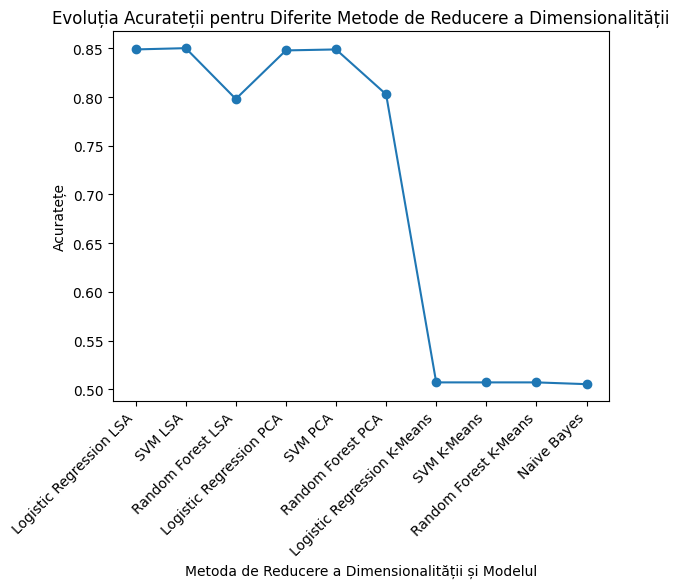

In [72]:
plt.plot(models.keys(), accuracies, marker='o', linestyle='-')
plt.title('Evoluția Acurateții pentru Diferite Metode de Reducere a Dimensionalității')
plt.xlabel('Metoda de Reducere a Dimensionalității și Modelul')
plt.ylabel('Acuratețe')
plt.xticks(rotation=45, ha='right')
plt.show()

### 5. În acest grafic se prezintă timpul de antrenare pentru diverse modele

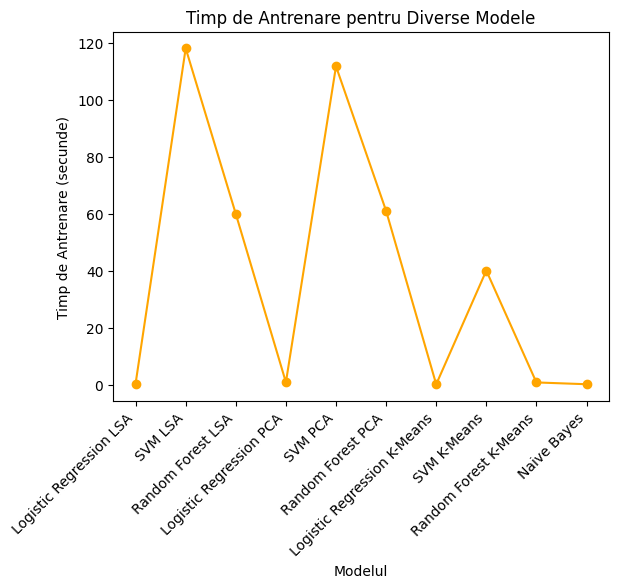

In [63]:
plt.plot(models.keys(), training_times, marker='o', linestyle='-', color='orange')
plt.title('Timp de Antrenare pentru Diverse Modele')
plt.xlabel('Modelul')
plt.ylabel('Timp de Antrenare (secunde)')
plt.xticks(rotation=45, ha='right')
plt.show()

### 6. Afișez cea mai bună acurațe împreună cu numele modelului

In [74]:
# Afișarea celui mai bun model
print(f"Cel mai bun model: {best_model_name} cu o acuratete de {best_accuracy}")

# Adăugarea rezultatelor pentru cel mai bun model în raportul general
results['Best Model'] = {
    'accuracy': best_accuracy,
}

Cel mai bun model: SVM LSA cu o acuratete de 0.8502269288956127


### 7. Am afișat matricea de confuzie pentru cel mai bun model

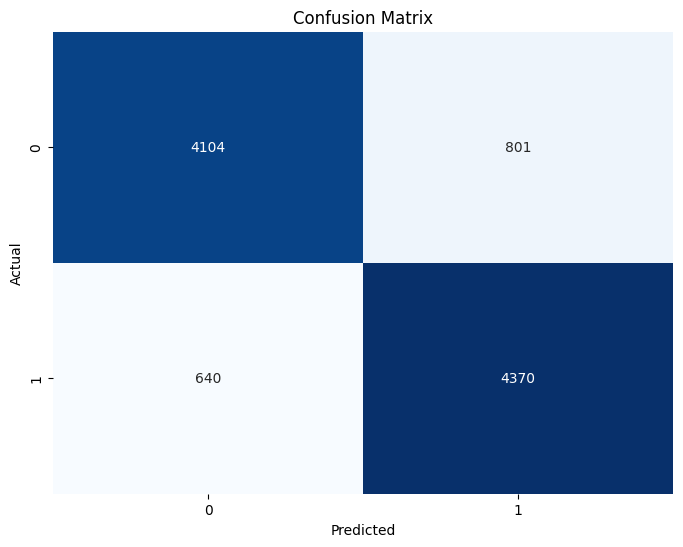

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

conf_matrix = conf_matrix_best

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()